<a href="https://colab.research.google.com/github/PinguimSurfante/triggo.ai/blob/main/trigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = "/content/drive/My Drive/archive/"
os.listdir(dataset_path)

['olist_order_payments_dataset.csv',
 'olist_customers_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv',
 'olist_products_dataset.csv']

# Libs

In [ ]:
!pip install -q pandas matplotlib seaborn scikit-learn plotly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Modelagem (predição de atraso)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly as px
from IPython.display import display
import ipywidgets as widgets

# Etapa 1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Importando os arquivos CSV
customers = pd.read_csv(dataset_path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(dataset_path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(dataset_path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(dataset_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(dataset_path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(dataset_path + 'olist_orders_dataset.csv')
products = pd.read_csv(dataset_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(dataset_path + 'olist_sellers_dataset.csv')
category_translation = pd.read_csv(dataset_path + 'product_category_name_translation.csv')

In [ ]:
# função para verificar rapidamente o estado dos dados: tamanho, nulos e duplicatas.
def resumo_df(df, nome):
    print(f"Dataset: {nome}")
    print("Dimensão:", df.shape)
    print("Duplicadas:", df.duplicated().sum())
    print("Valores nulos:\n", df.isnull().sum())
    print("-" * 40)

# Aplicando em todos
resumo_df(customers, "Customers")
resumo_df(geolocation, "Geolocation")
resumo_df(order_items, "Order Items")
resumo_df(order_payments, "Order Payments")
resumo_df(order_reviews, "Order Reviews")
resumo_df(orders, "Orders")
resumo_df(products, "Products")
resumo_df(sellers, "Sellers")
resumo_df(category_translation, "Category Translation")

Dataset: Customers
Dimensão: (99441, 5)
Duplicadas: 0
Valores nulos:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
----------------------------------------
Dataset: Geolocation
Dimensão: (1000163, 5)
Duplicadas: 261831
Valores nulos:
 geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
----------------------------------------
Dataset: Order Items
Dimensão: (112650, 7)
Duplicadas: 0
Valores nulos:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
----------------------------------------
Dataset: Order Payments
Dimensão: (103886, 5)
Duplicadas: 0
Valores nulos:
 order_id                0
payment_sequential      

In [ ]:
# Tratamentos dos NaN
# Decide criar a categoria "Outros" para conseguir aproveitar os dados que estavam NaN
products['product_category_name'] = products['product_category_name'].fillna('Outros')
products['product_name_lenght'] = products['product_name_lenght'].fillna(0).astype(float)
products['product_description_lenght'] = products['product_description_lenght'].fillna(0).astype(float)
products['product_photos_qty'] = products['product_photos_qty'].fillna(0).astype(float)

# Preenchimento dos dados faltantes de medidas físicas dos produtos com a mediana, o que é adequado para evitar distorções causadas por outliers (professora disse na aula q dados grandes é melhor mediana).
for col in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    products[col] = products[col].fillna(products[col].median()).astype(float)

In [ ]:
geolocation = geolocation.drop_duplicates()

In [ ]:
# Remove duplicadas do review_id
order_reviews = order_reviews.drop_duplicates(subset='review_id')

In [ ]:
#   Remoção de registros incompletos em campos essenciais para análise do fluxo logístico do pedido.
orders = orders.dropna(subset=['order_approved_at', 'order_delivered_carrier_date'])

In [ ]:
# Juntando tradução de categorias com produtos antes do merge com order_items
products = products.merge(category_translation, on='product_category_name', how='left')

# Agora os merges normalmente para transformar em 1 só tabela:
orders_full = orders.merge(order_items, on='order_id', how='inner')
orders_full = orders_full.merge(products, on='product_id', how='inner')
orders_full = orders_full.merge(sellers, on='seller_id', how='inner')
orders_full = orders_full.merge(order_payments, on='order_id', how='inner')
orders_full = orders_full.merge(order_reviews, on='order_id', how='left')

In [ ]:
print(orders_full.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english_x', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')


In [ ]:
# Remover o x e y para melhorar leitura:

orders_full = orders_full.rename(columns={
    'product_category_name_x': 'product_category_name',
    'product_name_lenght_x': 'product_name_lenght',
    'product_category_name_english_x': 'product_category_name_english',
    'product_description_lenght_x': 'product_description_lenght',
    'product_photos_qty_x': 'product_photos_qty',
    'product_weight_g_x': 'product_weight_g',
    'product_length_cm_x': 'product_length_cm',
    'product_height_cm_x': 'product_height_cm',
    'product_width_cm_x': 'product_width_cm',
    'seller_zip_code_prefix_x': 'seller_zip_code_prefix',
    'seller_city_x': 'seller_city',
    'seller_state_x': 'seller_state'
})

orders_full = orders_full.drop(columns=[col for col in orders_full.columns if col.endswith('_y' or col.endswith("_x"))])

In [ ]:
# Verificações de nulos
print(orders_full[['order_id', 'product_id', 'product_category_name']].isnull().sum())

order_id                 0
product_id               0
product_category_name    0
dtype: int64


In [ ]:
print(orders_full[['order_delivered_customer_date', 'review_score', 'price', 'freight_value']].isnull().sum())

order_delivered_customer_date    1328
review_score                     1523
price                               0
freight_value                       0
dtype: int64


In [ ]:
#  Tratamento final de nulos
orders_full['product_category_name_english'] = orders_full['product_category_name_english'].fillna('unknown')

orders_full = orders_full.assign(
    product_category_name_english=orders_full['product_category_name_english'].fillna('unknown')
)

In [ ]:
orders_full

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,1,boleto,1,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,1,credit_card,3,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116664,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,1,credit_card,3,195.00,29bb71b2760d0f876dfa178a76bc4734,4.0,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01
116665,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,b80910977a37536adeddd63663f916ad,...,1,credit_card,5,271.01,371579771219f6db2d830d50805977bb,5.0,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57
116666,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,...,1,credit_card,4,441.16,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56
116667,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2,d1c427060a0f73f6b889a5c7c61f2ac4,...,1,credit_card,4,441.16,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56


# Etapa 2

A)

In [ ]:
import sqlite3
conn = sqlite3.connect('orders.sqlite')  # nome do banco de dados
orders_full.to_sql('orders_full', conn, index=False, if_exists='replace')

116669

In [ ]:
pd.read_sql("SELECT * FROM orders_full LIMIT 5", conn)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,1,boleto,1,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,1,credit_card,3,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,None,None,2018-08-18 00:00:00,2018-08-22 19:07:58


In [ ]:
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full['order_purchase_timestamp'])
orders_full['order_month'] = orders_full['order_purchase_timestamp'].dt.to_period('M')

In [ ]:
print(orders_full['order_purchase_timestamp'].dtype)

datetime64[ns]


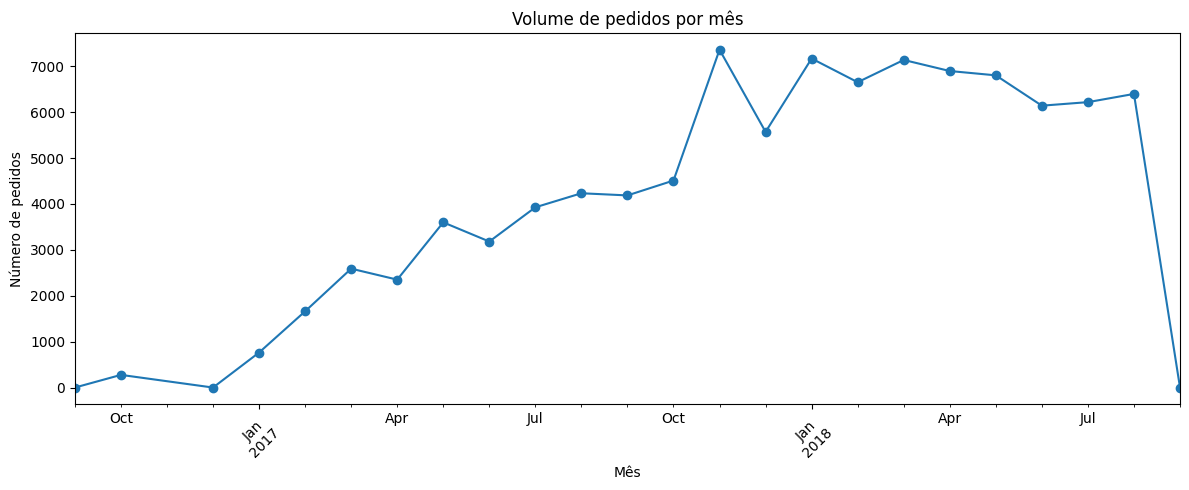

In [ ]:
# Volume de pedidos por mês (Python)
import matplotlib.pyplot as plt

orders_full['order_month'] = orders_full['order_purchase_timestamp'].dt.to_period('M')
pedidos_por_mes = orders_full.groupby('order_month')['order_id'].nunique()

plt.figure(figsize=(12,5))
pedidos_por_mes.plot(marker='o')
plt.title('Volume de pedidos por mês')
plt.xlabel('Mês')
plt.ylabel('Número de pedidos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# O volume de pedidos por mês mostra uma tendência de crescimento ao longo do tempo, especialmente entre o final de 2016 e meados de 2018.
# Observa-se um pico claro em novembro de 2017, indicando uma possível sazonalidade associada à Black Friday.
# Após esse pico, o volume se mantém relativamente alto e estável, com variações menores. Isso sugere que há sazonalidade nas vendas, especialmente no final do ano.

In [ ]:
pd.read_sql("SELECT order_purchase_timestamp, order_delivered_customer_date FROM orders_full LIMIT 5", conn)

,order_purchase_timestamp,order_delivered_customer_date


In [ ]:
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full['order_purchase_timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S').astype(str)
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date']).dt.strftime('%Y-%m-%d %H:%M:%S').astype(str)

In [ ]:
# Remover coluna com tipo Period
orders_full = orders_full.drop(columns=['order_month'], errors='ignore')

# Salvar no SQLite
conn = sqlite3.connect('orders.sqlite')
orders_full.to_sql('orders_full', conn, index=False, if_exists='replace')

115341

B)

In [ ]:
query_b = """
SELECT
  julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS tempo_entrega
FROM orders_full
WHERE order_delivered_customer_date IS NOT NULL;
"""
df_b_sql = pd.read_sql(query_b, conn)
df_b_sql

,tempo_entrega
0,8.436574
1,8.436574
2,8.436574
3,13.782037
4,9.394213
...,...
115336,22.193727
115337,24.859421
115338,17.086424
115339,17.086424


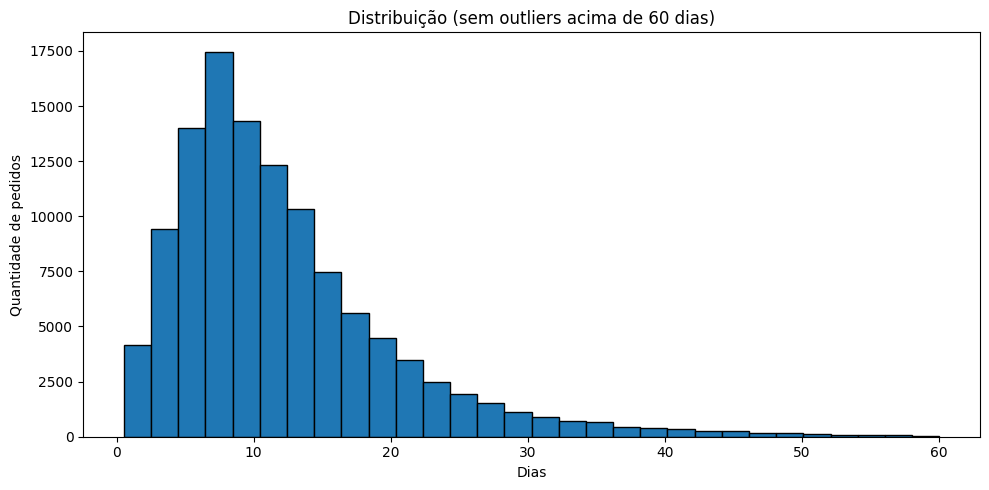

In [ ]:
# Filtrar para remover outliers acima de 60 dias
df_b_sql_filtrado = df_b_sql[df_b_sql['tempo_entrega'] <= 60]

plt.figure(figsize=(10,5))
plt.hist(df_b_sql_filtrado['tempo_entrega'], bins=30, edgecolor='black')
plt.title('Distribuição (sem outliers acima de 60 dias)')
plt.xlabel('Dias')
plt.ylabel('Quantidade de pedidos')
plt.tight_layout()
plt.show()

# A maioria dos pedidos é entregue entre 0 e 20 dias, com uma concentração forte em torno de 5 a 15 dias.
# Existem alguns casos extremos de entrega acima de 100 dias, considerados outliers, que foram removidos da análise para não distorcer a visualização.

C)

In [ ]:
# Remove colunas duplicadas com _y e mantém só _x
orders_full = orders_full.drop(columns=[col for col in orders_full.columns if col.endswith('_y')])

# Renomeia as colunas com _x para o nome original
orders_full.columns = [col.replace('_x', '') for col in orders_full.columns]

In [77]:
orders_full = orders_full.rename(columns={
    'customer_zip_code_prefix_x': 'customer_zip_code_prefix',
    'customer_state_x': 'customer_state',
    'customer_city_x': 'customer_city',
    'customer_unique_id_x': 'customer_unique_id'
})

In [76]:
print(orders_full.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'customer_unique_id_x', 'customer_zip_code_prefix_x', 'customer_city_x',
       'customer_state_x', 'zip_diff', 'customer_unique_id_y',
  

<ipython-input-94-61709d38bb2a>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_media = orders_full.groupby('faixa_dist')['freight_value'].mean().reset_index()


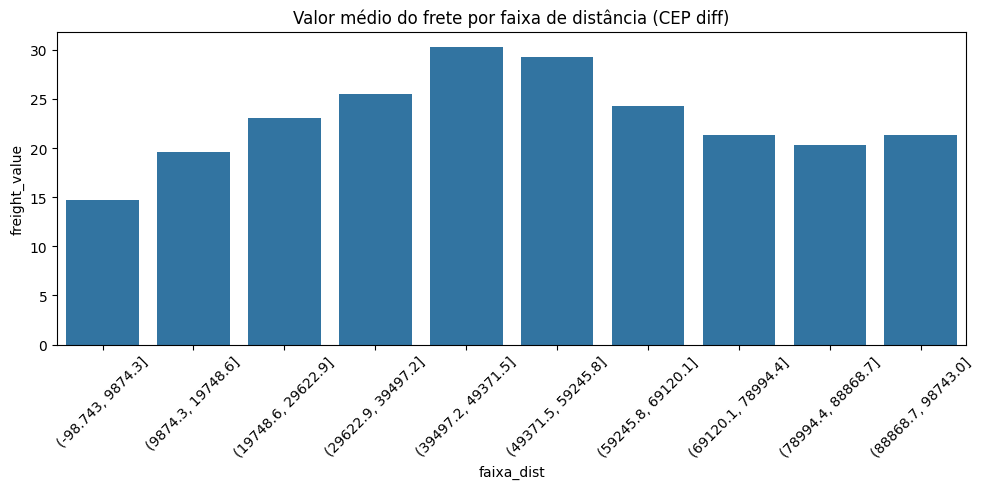

In [94]:
# Como a base não traz latitude/longitude dos pedidos, estimamos a distância pela diferença numérica entre os prefixos de CEPs (5 dígitos). Apesar de simplificada, essa métrica fornece uma ideia aproximada de deslocamento regional."
orders_full['zip_diff'] = (orders_full['customer_zip_code_prefix'] - orders_full['seller_zip_code_prefix']).abs()

orders_full['faixa_dist'] = pd.cut(orders_full['zip_diff'], bins=10)
df_media = orders_full.groupby('faixa_dist')['freight_value'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=df_media, x='faixa_dist', y='freight_value')
plt.title('Valor médio do frete por faixa de distância (CEP diff)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# A análise mostra que não há uma relação linear forte entre a distância (estimada pela diferença entre CEPs) e o valor do frete. Embora a expectativa fosse de fretes mais altos para entregas mais distantes,
# o gráfico revela uma grande variabilidade nos valores, sugerindo que o frete depende de múltiplos fatores além da distância física.

# OBS: Quando eu fiz ontem estava dando certo, hoje estava dando erro de key word, então renomeei e upei o csv do primeiro merge para dar certo, porém chegou uma hora em q eu clicava para rodar e uma hora foi, então acho q
# o google collab ele precisa de reload tbm

D)

In [ ]:
### d) Categorias com maior faturamento (SQL)
query_d = """
SELECT
  product_category_name_english,
  SUM(price) AS total_faturamento
FROM orders_full
GROUP BY product_category_name_english
ORDER BY total_faturamento DESC
LIMIT 10;
"""
df_d_sql = pd.read_sql(query_d, conn)
df_d_sql

,product_category_name_english,total_faturamento
0,health_beauty,1272476.58
1,watches_gifts,1213523.56
2,bed_bath_table,1086946.32
3,sports_leisure,992827.54
4,computers_accessories,921885.82
5,furniture_decor,747615.53
6,housewares,649935.54
7,cool_stuff,634823.56
8,auto,603256.80
9,garden_tools,493476.87


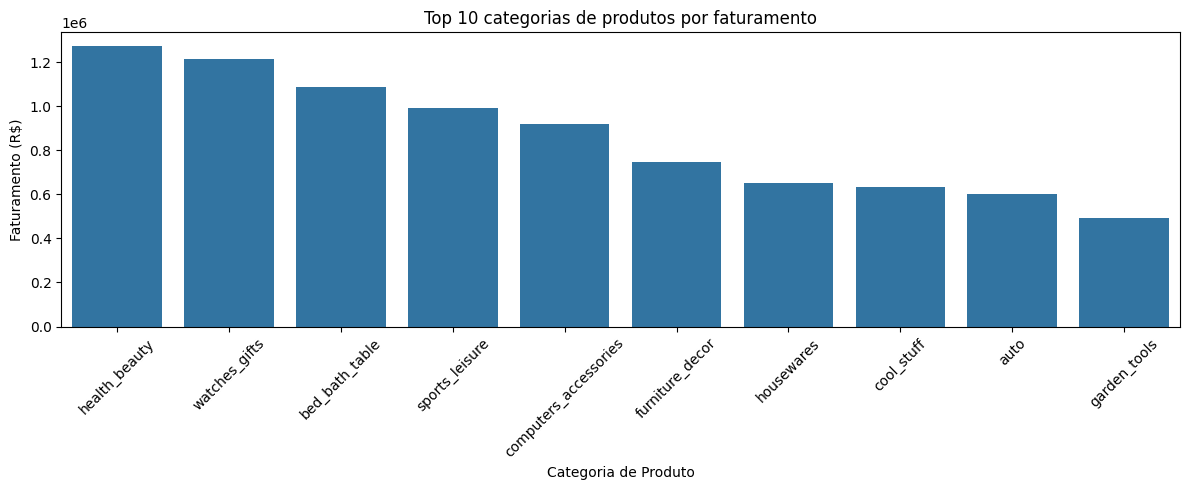

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(data=df_d_sql, x='product_category_name_english', y='total_faturamento')
plt.title('Top 10 categorias de produtos por faturamento')
plt.ylabel('Faturamento (R$)')
plt.xlabel('Categoria de Produto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# As categorias com maior faturamento são health_beauty, watches_gifts, e bed_bath_table.
# Essas categorias representam produtos com valor agregado mais alto, o que contribui significativamente para o faturamento, mesmo que o volume de vendas não seja necessariamente o maior.
# Isso mostra que, para o e-commerce, o tipo de produto vendido impacta mais no faturamento do que apenas o número de pedidos.

E)

<ipython-input-98-22d14910ecf4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


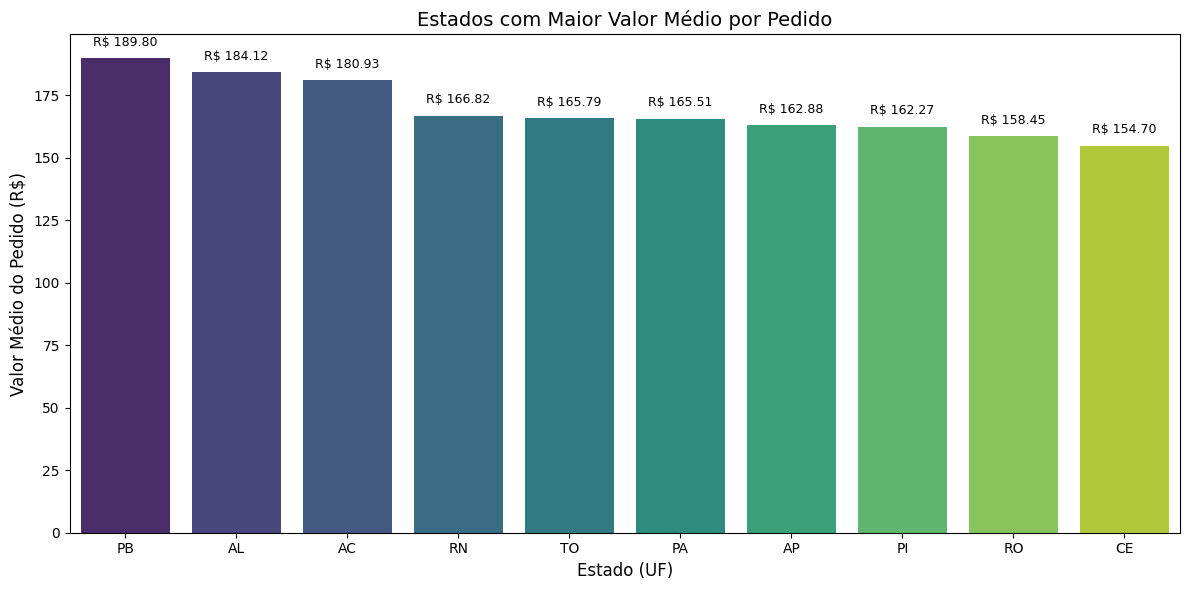

In [98]:
# Agrupar por estado do cliente (ou do vendedor)
df_valor_estado = orders_full.groupby('customer_state').agg(
    valor_medio_pedido=('price', 'mean')
).sort_values(by='valor_medio_pedido', ascending=False).reset_index()

# Visualizar os top 10
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_valor_estado.head(10),
    x='customer_state',
    y='valor_medio_pedido',
    palette='viridis'
)

# Adicionar os valores no topo de cada barra
for i, v in enumerate(df_valor_estado.head(10)['valor_medio_pedido']):
    plt.text(i, v + 5, f'R$ {v:.2f}', ha='center', fontsize=9)

plt.title('Estados com Maior Valor Médio por Pedido', fontsize=14)
plt.xlabel('Estado (UF)', fontsize=12)
plt.ylabel('Valor Médio do Pedido (R$)', fontsize=12)
plt.tight_layout()
plt.show()

# Os estados com maior valor médio de pedido são principalmente da região Nordeste e Norte do Brasil. A Paraíba (PB) se destaca com o maior ticket médio, seguida de Alagoas (AL) e Acre (AC).
# Isso mostra que, mesmo com menor volume de pedidos comparado a regiões como Sudeste e Sul, os consumidores desses estados tendem a fazer compras de valor mais alto — seja por produtos mais caros ou por pedidos mais completos.
# É interessante notar que estados como São Paulo e Rio de Janeiro, que têm alto volume de vendas, não aparecem entre os maiores valores médios, o que pode indicar um perfil de compra com ticket mais baixo, mas em maior quantidade.

In [99]:
conn.close()

# Etapa 3

A)

Taxa de clientes recorrentes: 2.97%


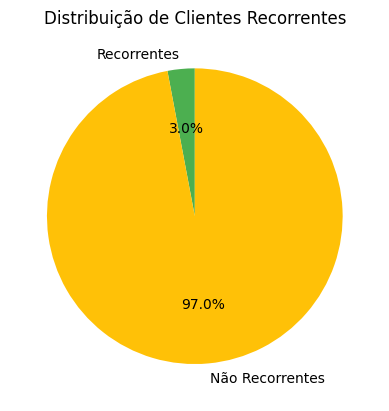

In [103]:
# Contar pedidos por cliente
pedidos_por_cliente = orders_full.groupby('customer_unique_id')['order_id'].nunique()

# Calcular taxa de recorrência
clientes_recorrentes = pedidos_por_cliente[pedidos_por_cliente > 1].count()
clientes_totais = pedidos_por_cliente.count()

taxa_recorrencia = clientes_recorrentes / clientes_totais
print(f"Taxa de clientes recorrentes: {taxa_recorrencia:.2%}")


plt.pie([clientes_recorrentes, clientes_totais - clientes_recorrentes],
        labels=['Recorrentes', 'Não Recorrentes'],
        autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107'])
plt.title('Distribuição de Clientes Recorrentes')
plt.show()


# Isso retorna que apenas 3% são clientes fiéis (fizeram + de 1 compra) os outros 97% compraram apenas 1 vez
# Sugerindo uma baixa retenção e representa uma excelente oportunidade para o negócio investir em programas de fidelidade, campanhas de reativação e e-mails pós-compra com o objetivo de aumentar a recompra.

B)

In [104]:
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date'])
orders_full['order_estimated_delivery_date'] = pd.to_datetime(orders_full['order_estimated_delivery_date'])

orders_full['entregue_atrasado'] = (orders_full['order_delivered_customer_date'] > orders_full['order_estimated_delivery_date']).astype(int)

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

features = ['freight_value', 'payment_value', 'product_weight_g', 'product_photos_qty']
df_model = orders_full[features + ['entregue_atrasado']].dropna()

X = df_model[features]
y = df_model['entregue_atrasado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

# Apesar de simples, o modelo mostrou-se eficiente em identificar pedidos pontuais, mas precisa de ajustes para melhorar a detecção de atrasos.
# Entre as melhorias possíveis estão:
# Balancear as classes do dataset (por exemplo, com técnicas como SMOTE)
# Incluir novas variáveis, como tempo estimado de entrega, região do cliente, ou tipo de produto
# Testar outros modelos e tunar hiperparâmetros
# Esse modelo pode servir como um ponto de partida para prever atrasos e apoiar decisões logísticas na empresa.

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     21127
           1       0.46      0.17      0.25      1752

    accuracy                           0.92     22879
   macro avg       0.70      0.58      0.60     22879
weighted avg       0.90      0.92      0.90     22879



3.

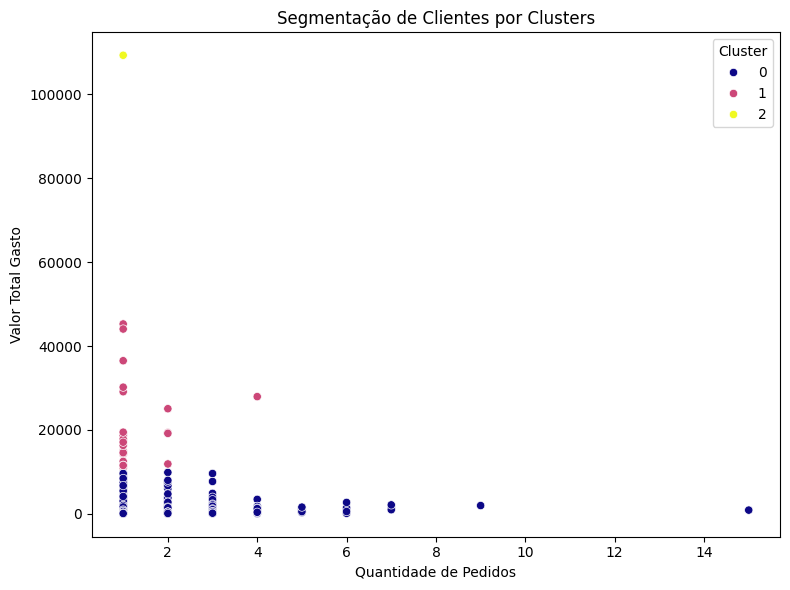

In [108]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Exemplo de agrupamento por valor total gasto e número de pedidos
clientes_df = orders_full.groupby('customer_unique_id').agg({
    'order_id': 'nunique',
    'payment_value': 'sum'
}).rename(columns={'order_id': 'qtd_pedidos', 'payment_value': 'valor_total'})

scaler = StandardScaler()
clientes_scaled = scaler.fit_transform(clientes_df)

kmeans = KMeans(n_clusters=3, random_state=42)
clientes_df['cluster'] = kmeans.fit_predict(clientes_scaled)

# Visualização
plt.figure(figsize=(8,6))
sns.scatterplot(data=clientes_df, x='qtd_pedidos', y='valor_total', hue='cluster', palette='plasma')
plt.title('Segmentação de Clientes por Clusters')
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Valor Total Gasto')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# A segmentação de clientes com KMeans permitiu identificar três grupos distintos de comportamento. A maioria dos clientes realiza apenas um pedido, enquanto uma pequena parcela apresenta um alto valor de compra e frequência.
# Com base nisso, é possível aplicar estratégias de marketing personalizadas para cada perfil, com foco em retenção, aumento do ticket médio e fidelização dos melhores clientes.

D)

In [109]:
# Garantir tipos datetime
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full['order_purchase_timestamp'])
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date'])

# Criar coluna com tempo de entrega em dias
orders_full['tempo_entrega'] = (orders_full['order_delivered_customer_date'] - orders_full['order_purchase_timestamp']).dt.days

# Selecionar colunas relevantes
df_satisfacao = orders_full[['review_score', 'tempo_entrega', 'price', 'freight_value', 'product_category_name_english']]
df_satisfacao = df_satisfacao.dropna()

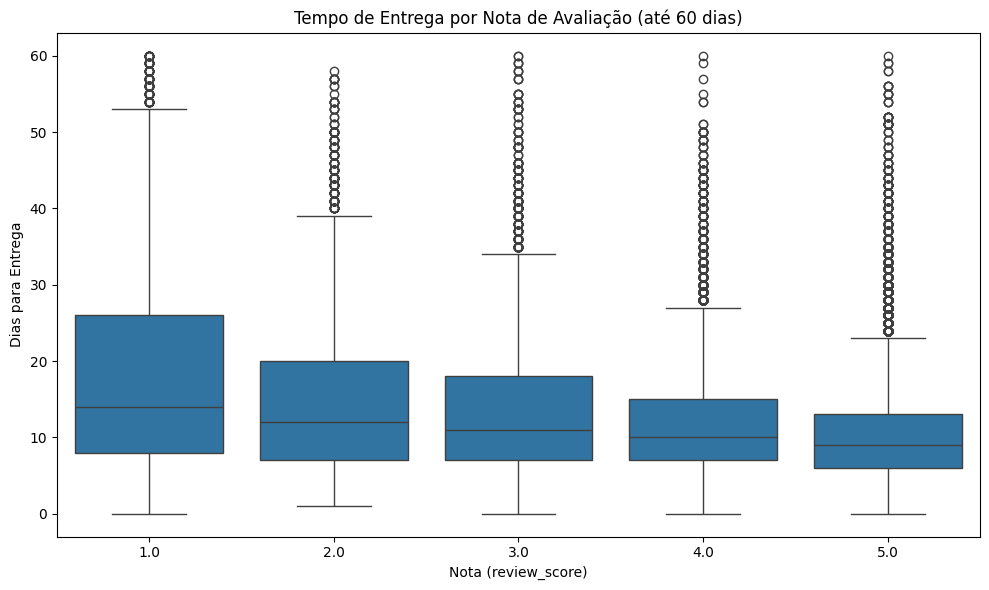

In [114]:
df_plot = df_satisfacao[df_satisfacao['tempo_entrega'] <= 60]
plt.figure(figsize=(10,6))
sns.boxplot(data=df_plot, x='review_score', y='tempo_entrega')
plt.title('Tempo de Entrega por Nota de Avaliação (até 60 dias)')
plt.xlabel('Nota (review_score)')
plt.ylabel('Dias para Entrega')
plt.tight_layout()
plt.show()

<ipython-input-117-b73f80ea9736>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_media_preco, x='review_score', y='price', palette='Blues')


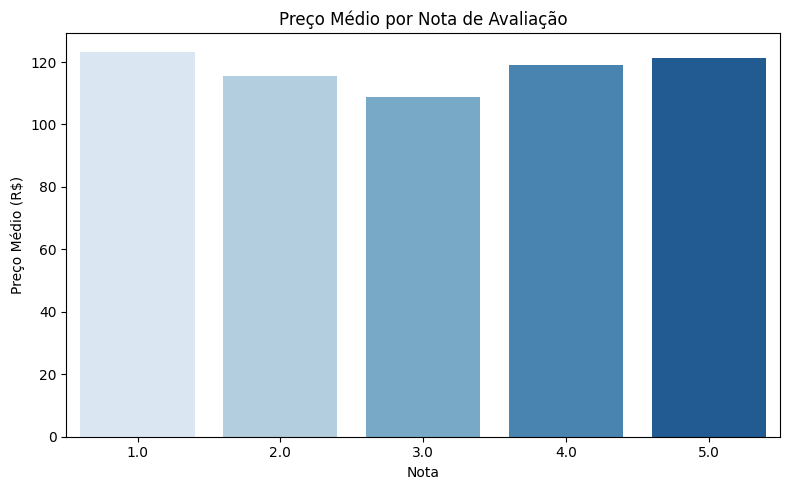

In [117]:
df_media_preco = df_satisfacao.groupby('review_score')['price'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=df_media_preco, x='review_score', y='price', palette='Blues')
plt.title('Preço Médio por Nota de Avaliação')
plt.ylabel('Preço Médio (R$)')
plt.xlabel('Nota')
plt.tight_layout()
plt.show()

O gráfico mostra que o valor médio do pedido não varia muito com a nota dada pelo cliente.
Isso sugere que o preço por si só não é o principal fator de insatisfação.
Clientes que gastaram mais também deram notas baixas, o que reforça a importância de outros fatores — como entrega e atendimento.

<ipython-input-118-c70d080cce34>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_media_frete, x='review_score', y='freight_value', palette='Purples')


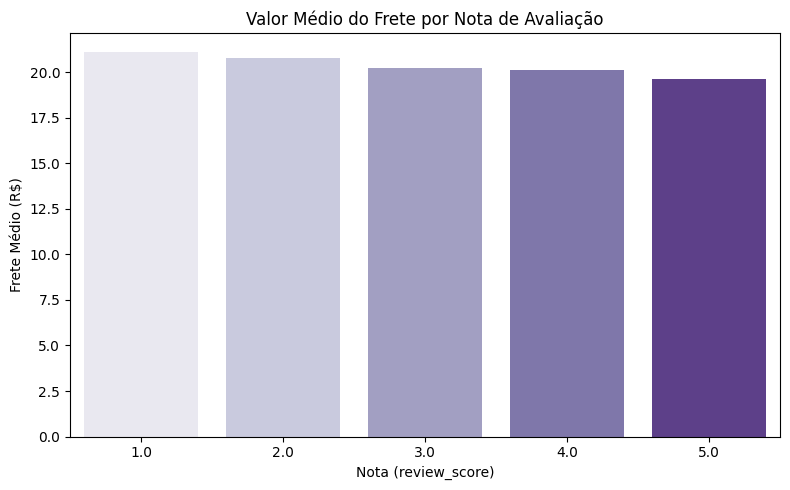

In [118]:
df_media_frete = df_satisfacao.groupby('review_score')['freight_value'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=df_media_frete, x='review_score', y='freight_value', palette='Purples')
plt.title('Valor Médio do Frete por Nota de Avaliação')
plt.xlabel('Nota (review_score)')
plt.ylabel('Frete Médio (R$)')
plt.tight_layout()
plt.show()

O gráfico mostra se clientes que pagaram mais frete estão mais (ou menos) satisfeitos.
Se notas 1 e 2 tiverem frete médio mais alto, isso pode indicar insatisfação com o custo de envio, o que é um insight valioso para o negócio.

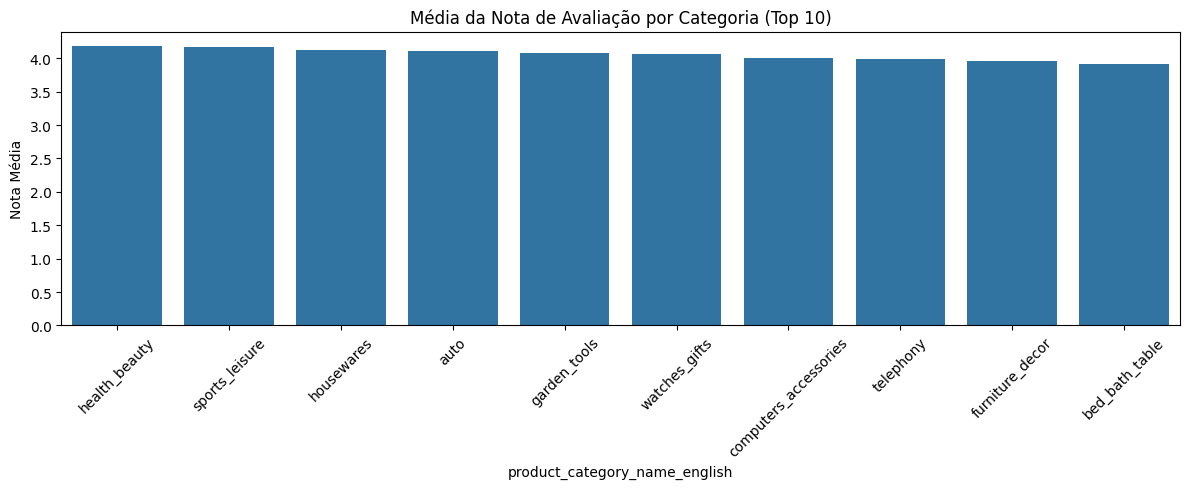

In [113]:
top_categorias = df_satisfacao['product_category_name_english'].value_counts().head(10).index

df_top = df_satisfacao[df_satisfacao['product_category_name_english'].isin(top_categorias)]
categoria_score = df_top.groupby('product_category_name_english')['review_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=categoria_score.index, y=categoria_score.values)
plt.title('Média da Nota de Avaliação por Categoria (Top 10)')
plt.ylabel('Nota Média')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As notas médias nas principais categorias variam entre ≈ 3.8 e 4.2, mostrando que, no geral, os clientes estão satisfeitos.
Contudo, algumas categorias como furniture_decor e bed_bath_table têm médias um pouco mais baixas — indicando possíveis problemas na entrega, qualidade ou expectativa do cliente.
Isso pode orientar o negócio a revisar logística, descrição ou atendimento em categorias com nota menor.

# Etapa 4

1)

In [119]:
[col for col in orders_full.columns if 'product_category_name_english' in col]

['product_category_name_english']

In [120]:
orders_full.loc[:, 'order_month'] = pd.to_datetime(orders_full['order_purchase_timestamp']).dt.to_period('M')

In [121]:
orders_full['order_month'] = pd.to_datetime(orders_full['order_purchase_timestamp']).dt.to_period('M').astype(str)

vendas_facet = orders_full.groupby(
    ['order_month', 'customer_state', 'product_category_name_english']
)['price'].sum().reset_index()

In [122]:
import plotly.graph_objects as go

estados = vendas_facet['customer_state'].unique()
traces = []
trace_infos = []

# Criar os traces com info de estado + categoria
for estado in estados:
    df_uf = vendas_facet[vendas_facet['customer_state'] == estado]
    for categoria in df_uf['product_category_name_english'].unique():
        df_cat = df_uf[df_uf['product_category_name_english'] == categoria]
        traces.append(go.Scatter(
            x=df_cat['order_month'],
            y=df_cat['price'],
            mode='lines',
            name=categoria,
            visible=(estado == 'SP')
        ))
        trace_infos.append((estado, categoria))  # salvar origem do trace

# Criar dropdowns com visibilidade correta
dropdown_buttons = []
for estado in estados:
    visible_flags = [(e == estado) for (e, c) in trace_infos]
    dropdown_buttons.append({
        'label': estado,
        'method': 'update',
        'args': [
            {'visible': visible_flags},
            {'title': f'Faturamento por Categoria — {estado}'}
        ]
    })

# Construir figura
fig = go.Figure(data=traces)

fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1.1,
        'y': 1.15
    }],
    title='Faturamento por Categoria — AL',
    xaxis_title='Mês',
    yaxis_title='Faturamento (R$)',
    template='plotly_white',
    height=600
)

fig.show()

2)

In [129]:
vendas_estado = orders_full.groupby('customer_state')['price'].sum().reset_index()
vendas_estado = vendas_estado.sort_values(by='price', ascending=True)

fig = px.bar(
    vendas_estado,
    x='price',
    y='customer_state',
    orientation='h',
    color='price',
    color_continuous_scale='Viridis',
    title='Faturamento Total por Estado — Brasil',
    labels={
        'customer_state': 'Estado',
        'price': 'Faturamento (R$)'
    },
    template='plotly_white',
    height=600
)

fig.update_layout(
    coloraxis_colorbar=dict(title='Faturamento'),
    xaxis_tickformat=',.0f',
    xaxis_title='Faturamento Total (R$)',
    yaxis_title='UF (Estado)',
    margin=dict(l=100, r=30, t=50, b=50)
)

fig.show()

O gráfico mostra que São Paulo  lidera com folga o faturamento, seguido por Rio de Janeiro e Minas Gerais.
Esses três estados concentram boa parte das vendas da Olist, o que pode guiar estratégias regionais, alocação de estoque e investimentos em marketing.
Já estados com menor faturamento podem representar oportunidades para campanhas locais ou expansão logística.

3)

In [128]:
df_avaliacao_limpo = orders_full[['review_score', 'tempo_entrega']].dropna()

fig = px.box(
    df_avaliacao_limpo,
    x='review_score',
    y='tempo_entrega',
    points=False,
    title='Entrega por Nota do Cliente (Sem Outliers)',
    labels={
        'review_score': 'Nota do Cliente',
        'tempo_entrega': 'Tempo de Entrega (dias)'
    },
    color='review_score',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    template='plotly_white',
    height=450,
    xaxis=dict(tickmode='linear'),
    showlegend=False
)

fig.show()

O gráfico mostra que a mediana do tempo de entrega se mantém relativamente constante entre as notas 3, 4 e 5.
No entanto, notas mais baixas (1 e 2) possuem maior dispersão e tempos máximos maiores, o que sugere que atrasos extremos podem ser um fator decisivo para avaliações ruins.
Mesmo que o tempo médio seja parecido, atrasos fora do padrão geram insatisfação clara.

In [127]:
vendedores = orders_full.groupby('seller_id').agg({
    'order_id': 'count',
    'review_score': 'mean',
    'tempo_entrega': 'mean'
}).reset_index().rename(columns={
    'order_id': 'volume_vendas',
    'review_score': 'avaliacao_media',
    'tempo_entrega': 'tempo_medio_entrega'
})

top_vendedores = vendedores.sort_values(by='volume_vendas', ascending=False).head(20)

fig_vendedores = px.scatter(
    top_vendedores,
    x='tempo_medio_entrega',
    y='avaliacao_media',
    size='volume_vendas',
    hover_name='seller_id',
    color='volume_vendas',
    color_continuous_scale='Turbo',
    title='🏆 Análise dos Top 20 Vendedores: Entrega x Satisfação',
    labels={
        'tempo_medio_entrega': 'Tempo Médio de Entrega (dias)',
        'avaliacao_media': 'Nota Média',
        'volume_vendas': 'Volume de Vendas'
    },
    template='plotly_white'
)
fig_vendedores.show()

O gráfico mostra uma visão clara dos principais vendedores da plataforma.
Os melhores vendedores combinam alta avaliação, entrega rápida e grande volume (bolhas grandes, na parte superior esquerda).
Já vendedores com tempo médio elevado e avaliações baixas (inferior direito) devem ser monitorados — podem estar impactando a satisfação geral dos clientes.
Esse tipo de análise pode ser usada para recompensar os top performers e melhorar a performance dos outliers negativos.